In [12]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from enum import IntEnum

# prefix = "AMZN_2012-06-21_34200000_57600000"
prefix = "INTC_2012-06-21_34200000_57600000"

trades_data_file = f"./data/{prefix}_message_5.csv"
orderbook_data_file = f"./data/{prefix}_orderbook_5.csv"

trade_df = pd.read_csv(trades_data_file, names=(
    'time',
    'type',
    'orderId',
    'size',
    'price',
    'direction'
))

orderbook_df = pd.read_csv(orderbook_data_file, names=(
    'ask1_price',
    'ask1_size',
    'bid1_price',
    'bid1_size',

    'ask2_price',
    'ask2_size',
    'bid2_price',
    'bid2_size',

    'ask3_price',
    'ask3_size',
    'bid3_price',
    'bid3_size',

    'ask4_price',
    'ask4_size',
    'bid4_price',
    'bid4_size',

    'ask5_price',
    'ask5_size',
    'bid5_price',
    'bid5_size',
))

df = pd.concat([trade_df, orderbook_df], axis=1)

Event sizing: 477.3022253584152 928.0965530809582
Average time between events (seconds): 0.040273278440329144


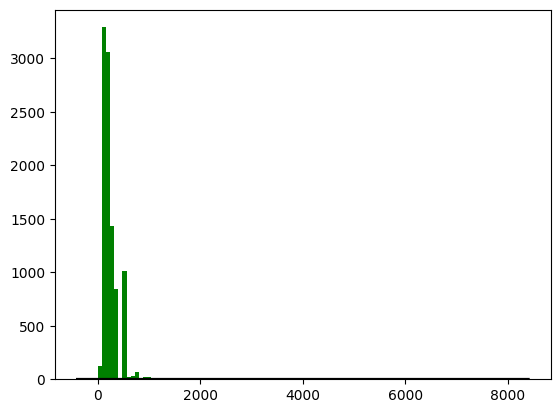

In [31]:
from scipy import stats

average_event_size = df['size'].mean()
event_sigma = df['size'].std()
average_time_between_events = df['time'].diff().mean()

print("Event sizing:", average_event_size, df['size'].std())
print("Average time between events (seconds):", average_time_between_events)

data = df['size'][:10_000]

ae, loce, scalee = stats.skewnorm.fit(data)

# Plot the PDF.
plt.figure()
plt.hist(data, bins=100, color='g')

xmin, xmax = plt.xlim()

x = np.linspace(xmin, xmax, 100)
p = stats.skewnorm.pdf(x,ae, loce, scalee)#.rvs(100)

plt.plot(x, p, 'k', linewidth=2)

Average spread: 1.2455639123625286


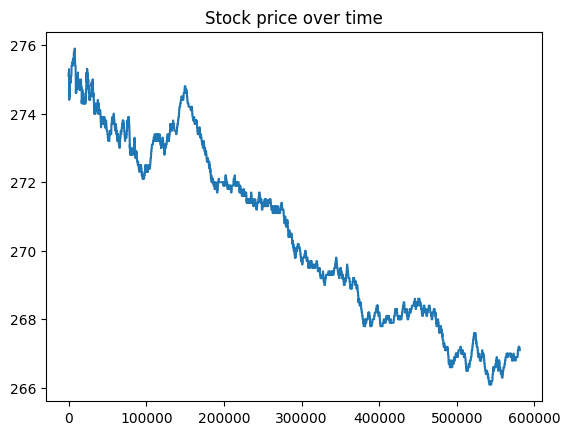

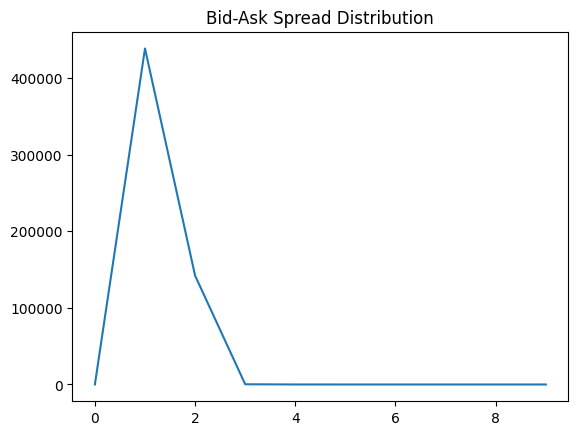

In [9]:
# 0.01 * 1000 = 10
spread = df['ask1_price'] - df['bid1_price']
print("Average spread:", np.mean(spread) / 100)

spreads = np.zeros((10, 1))

for i in range(0, 10):
    current_spread = df[(df['ask1_price'] - df['bid1_price']) == 100 * i]
    spreads[i] = len(current_spread)

plt.plot(df['bid1_price'] / 1000)
plt.title("Stock price over time")
plt.show()

plt.plot(spreads)
plt.title("Bid-Ask Spread Distribution")
plt.show()

Average event size (queue 1): 483.74239536593785
Average event size (queue 2): 449.934287127155
Average event size (queue 3): 451.1815613416508


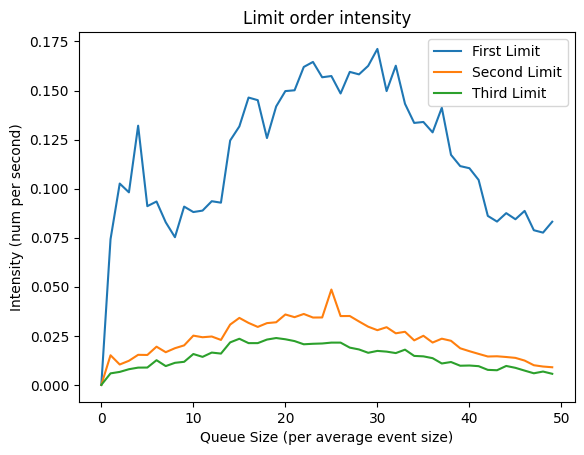

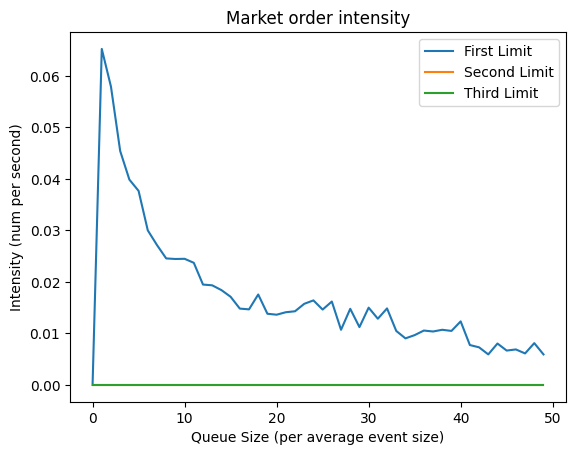

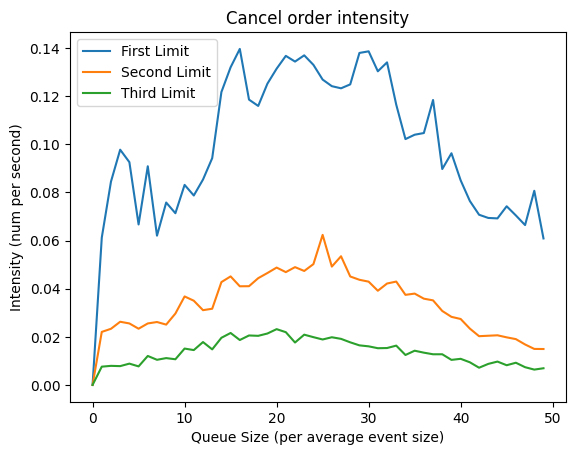

In [10]:
class OrderType(IntEnum):
    NewOrder = 1
    Cancellation = 2
    Deletion = 3
    Execution = 4
    HiddenExecution = 5
    TradingHalt = 7


class OrderDirection(IntEnum):
    Sell = -1
    Buy = 1


DEPTH = 3

ORDER_TYPES = 3

lambdas = np.zeros((DEPTH, ORDER_TYPES, 50))


event_in_queue = [

    (df['ask1_price'] == df['price']) | (df['bid1_price'] == df['price']),

    (df['ask2_price'] == df['price']) | (df['bid2_price'] == df['price']),

    (df['ask3_price'] == df['price']) | (df['bid3_price'] == df['price'])
]


average_event_size = [
    df[event_in_queue[0]]['size'].mean(),
    df[event_in_queue[1]]['size'].mean(),
    df[event_in_queue[2]]['size'].mean()
]


print("Average event size (queue 1):", average_event_size[0])

print("Average event size (queue 2):", average_event_size[1])

print("Average event size (queue 3):", average_event_size[2])


queue_size = np.ceil(df['bid1_size'].astype(float) / average_event_size[0])

trading_day_in_seconds = 27_000

for x in range(0, DEPTH):

    for i in range(0, 50):

        isInQueueBucket = queue_size == i


        isLimitOrder = df['type'] == 1

        isMarketOrder = (df['type'] == 4) | (df['type'] == 5)

        isCancelOrder = (df['type'] == 2) | (df['type'] == 3)


        lambdas[x, 0, i] = len(df[isInQueueBucket & isLimitOrder &
                                  event_in_queue[x]]) / trading_day_in_seconds

        lambdas[x, 1, i] = len(df[isInQueueBucket & isMarketOrder &
                                  event_in_queue[x]]) / trading_day_in_seconds

        lambdas[x, 2, i] = len(df[isInQueueBucket & isCancelOrder &
                                  event_in_queue[x]]) / trading_day_in_seconds


for i in range(0, ORDER_TYPES):

    plt.plot(lambdas[0][i], label="First Limit")

    plt.plot(lambdas[1][i], label="Second Limit")

    plt.plot(lambdas[2][i], label="Third Limit")

    plt.ylabel("Intensity (num per second)")

    plt.xlabel("Queue Size (per average event size)")

    plt.legend()
    if (i == 0):

        order_type = "Limit"
    elif (i == 1):

        order_type = "Market"

    else:

        order_type = "Cancel"


    plt.title(f"{order_type} order intensity")

    plt.show()